# **AI Model of Carkir**


## import the libraries

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.8.0


In [3]:
!python --version

Python 3.7.13


## extracting the dataset and splitting it to train and validation dataset

In [4]:
local_zip = '/content/parking-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
source_path = '/content/Parking Slot'

source_path_empty = os.path.join(source_path, 'empty')
source_path_occupied = os.path.join(source_path, 'occupied')

print(f"There {len(os.listdir(source_path_empty))} images of empty parking slot.")
print(f"There {len(os.listdir(source_path_occupied))} images of occupied parking slot.")

There 622 images of empty parking slot.
There 802 images of occupied parking slot.


In [6]:
root_dir = '/content/parking-slot'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  os.mkdir('/content/parking-slot')
  os.mkdir('/content/parking-slot/training')
  os.mkdir('/content/parking-slot/validation')
  os.mkdir('/content/parking-slot/training/empty')
  os.mkdir('/content/parking-slot/training/occupied')
  os.mkdir('/content/parking-slot/validation/empty')
  os.mkdir('/content/parking-slot/validation/occupied')

  pass

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [7]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  files=[]
  for filename in os.listdir(SOURCE_DIR):
    file = SOURCE_DIR + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print('File is empty')

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    src_file = SOURCE_DIR + filename
    dest_file = TRAINING_DIR + filename
    copyfile(src_file, dest_file)
    
  for filename in testing_set:
    src_file = SOURCE_DIR + filename
    dest_file = VALIDATION_DIR + filename
    copyfile(src_file, dest_file)

In [8]:
EMPTY_SOURCE_DIR = "/content/Parking Slot/empty/"
OCCUPIED_SOURCE_DIR = "/content/Parking Slot/occupied/"

TRAINING_DIR = "/content/parking-slot/training/"
VALIDATION_DIR = "/content/parking-slot/validation/"

TRAINING_EMPTY_DIR = os.path.join(TRAINING_DIR, "empty/")
VALIDATION_EMPTY_DIR = os.path.join(VALIDATION_DIR, "empty/")

TRAINING_OCCUPIED_DIR = os.path.join(TRAINING_DIR, "occupied/")
VALIDATION_OCCUPIED_DIR = os.path.join(VALIDATION_DIR, "occupied/")

if len(os.listdir(TRAINING_EMPTY_DIR)) > 0:
  for file in os.scandir(TRAINING_EMPTY_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_OCCUPIED_DIR)) > 0:
  for file in os.scandir(TRAINING_OCCUPIED_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_EMPTY_DIR)) > 0:
  for file in os.scandir(VALIDATION_EMPTY_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_OCCUPIED_DIR)) > 0:
  for file in os.scandir(VALIDATION_OCCUPIED_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

split_data(EMPTY_SOURCE_DIR, TRAINING_EMPTY_DIR, VALIDATION_EMPTY_DIR, split_size)
split_data(OCCUPIED_SOURCE_DIR, TRAINING_OCCUPIED_DIR, VALIDATION_OCCUPIED_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_EMPTY_DIR))} images of empty parking slot for training")
print(f"There are {len(os.listdir(TRAINING_OCCUPIED_DIR))} images of occupied parking slot for training")
print(f"There are {len(os.listdir(VALIDATION_EMPTY_DIR))} images of empty parking slot for validation")
print(f"There are {len(os.listdir(VALIDATION_OCCUPIED_DIR))} images of occupied parking slot for validation")



There are 559 images of empty parking slot for training
There are 721 images of occupied parking slot for training
There are 63 images of empty parking slot for validation
There are 81 images of occupied parking slot for validation


## making the model with transfer learning

In [9]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import optimizers

pre_trained_model = VGG16(weights = "imagenet", include_top=False, input_shape = (48, 48, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
x = pre_trained_model.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5)

TRAINING_DIR = '/content/parking-slot/training'
VALIDATION_DIR = '/content/parking-slot/validation'

train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                    target_size = (48, 48),
                                                    batch_size = 32,
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                    target_size = (48, 48),
                                                    batch_size = 32,
                                                    class_mode = "categorical")

Found 1280 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


## train the model

In [12]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
40/40 [==============================] - 14s 63ms/step - loss: 0.7158 - accuracy: 0.5977 - val_loss: 0.4450 - val_accuracy: 0.9028
Epoch 2/15
40/40 [==============================] - 2s 51ms/step - loss: 0.4288 - accuracy: 0.8008 - val_loss: 0.2335 - val_accuracy: 0.9167
Epoch 3/15
40/40 [==============================] - 3s 68ms/step - loss: 0.2428 - accuracy: 0.9187 - val_loss: 0.1479 - val_accuracy: 0.9444
Epoch 4/15
40/40 [==============================] - 2s 50ms/step - loss: 0.1496 - accuracy: 0.9531 - val_loss: 0.1344 - val_accuracy: 0.9375
Epoch 5/15
40/40 [==============================] - 2s 50ms/step - loss: 0.1342 - accuracy: 0.9586 - val_loss: 0.0847 - val_accuracy: 0.9653
Epoch 6/15
40/40 [==============================] - 2s 50ms/step - loss: 0.1055 - accuracy: 0.9672 - val_loss: 0.0810 - val_accuracy: 0.9722
Epoch 7/15
40/40 [==============================] - 2s 50ms/step - loss: 0.0855 - accuracy: 0.9742 - val_loss: 0.0717 - val_accuracy: 0.9722
Epoch 8/15
4

Text(0.5, 1.0, 'Training and validation loss')

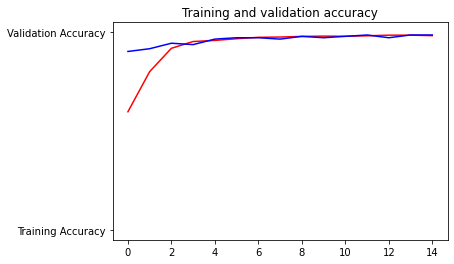

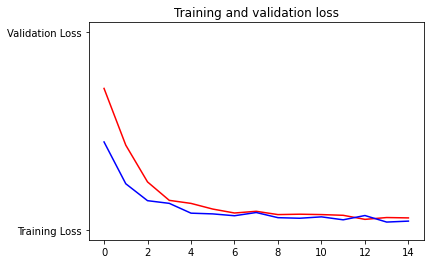

In [13]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

## save the model

In [14]:
!mkdir -p saved_model
model.save('saved_model/carkir')

INFO:tensorflow:Assets written to: saved_model/carkir/assets


In [15]:
# my_model directory
! ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
! ls saved_model/carkir

carkir
assets	keras_metadata.pb  saved_model.pb  variables


In [19]:
model.save('carkir.h5')